Training V1... Done (R2=0.9347, RMSE=0.0596)
Training V2... Done (R2=0.9315, RMSE=0.0610)
Training V3... Done (R2=0.9678, RMSE=0.0419)
Training V4... Done (R2=0.9832, RMSE=0.0302)
Training V5... Done (R2=0.9466, RMSE=0.0539)
Training V6... Done (R2=0.9534, RMSE=0.0503)
Training V7... Done (R2=0.9440, RMSE=0.0552)
V1: R2=0.9347, RMSE=0.0596, Sens=0.00%
V2: R2=0.9315, RMSE=0.0610, Sens=0.00%
V3: R2=0.9678, RMSE=0.0419, Sens=8.27%
V4: R2=0.9832, RMSE=0.0302, Sens=3.28%
V5: R2=0.9466, RMSE=0.0539, Sens=17.01%
V6: R2=0.9534, RMSE=0.0503, Sens=15.01%
V7: R2=0.9440, RMSE=0.0552, Sens=7.19%


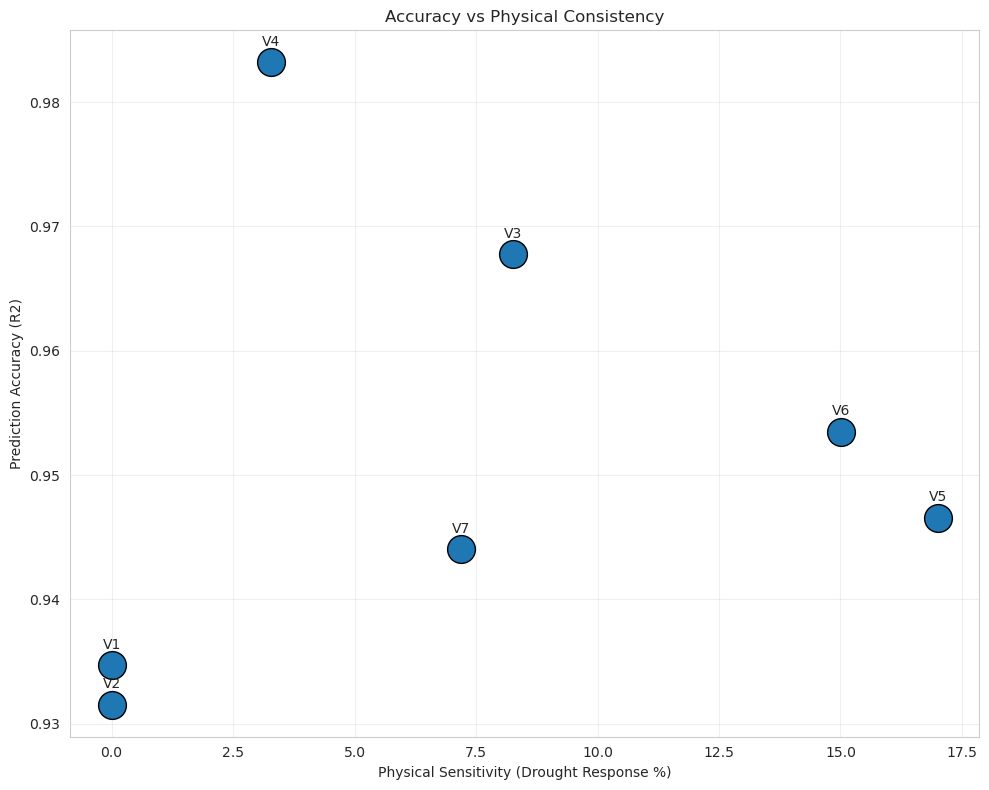

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import copy
import warnings

# ----------------------
# Configuration
# ----------------------
torch.manual_seed(42)
np.random.seed(42)
warnings.filterwarnings("ignore")

CSV_FILE = 'master_data_for_all_models_weekly.csv'
TARGET_COL = 'LAI'
SEQ_LENGTH = 12
TRAIN_END_DATE = '2018-12-31'
TEST_START_DATE = '2019-01-01'
BATCH_SIZE = 16

CLIMATE_FEATURES = [
    'total_precipitation',
    'volumetric_soil_water_layer_1',
    'volumetric_soil_water_layer_2',
    '2m_temperature',
    'surface_solar_radiation_downwards',
    'evaporation',
    'specific_humidity'
]

TIME_FEATURES = ['month_sin', 'month_cos']
LAG_FEATURE = ['LAI_lag_1']

F_BASE = CLIMATE_FEATURES
F_LAG = CLIMATE_FEATURES + LAG_FEATURE
F_CLIM_ONLY = CLIMATE_FEATURES + TIME_FEATURES
F_FULL = CLIMATE_FEATURES + LAG_FEATURE + TIME_FEATURES

F_V6_ORDERED = CLIMATE_FEATURES + LAG_FEATURE + TIME_FEATURES
V6_CLIMATE_DIM = len(CLIMATE_FEATURES)
V6_INERTIA_DIM = len(LAG_FEATURE) + len(TIME_FEATURES)

# ----------------------
# Utilities
# ----------------------
class EarlyStopping:
    def __init__(self, patience=15, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_weights = copy.deepcopy(model.state_dict())
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model_weights = copy.deepcopy(model.state_dict())
            self.counter = 0

def process_data(df):
    df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
    df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)
    df['LAI_lag_1'] = df['LAI'].shift(1)
    return df.dropna()

def create_sequences(features, targets, seq_length):
    xs, ys = [], []
    for i in range(len(features) - seq_length):
        xs.append(features[i:i + seq_length])
        ys.append(targets[i + seq_length])
    return np.array(xs), np.array(ys)

def get_data_loaders(df, features, target_col):
    df_train = df.loc[:TRAIN_END_DATE]

    scaler_x = MinMaxScaler().fit(df_train[features].values)
    scaler_y = MinMaxScaler().fit(df_train[[target_col]].values)

    X_train = scaler_x.transform(df_train[features].values)
    y_train = scaler_y.transform(df_train[[target_col]].values)

    X_train_seq, y_train_seq = create_sequences(X_train, y_train, SEQ_LENGTH)

    raw_X = df[features].values
    raw_y = df[[target_col]].values
    test_start_idx = np.where(df.index >= TEST_START_DATE)[0][0]

    X_test_ext = scaler_x.transform(raw_X[test_start_idx - SEQ_LENGTH:])
    y_test_ext = scaler_y.transform(raw_y[test_start_idx - SEQ_LENGTH:])

    X_test_seq, _ = create_sequences(X_test_ext, y_test_ext, SEQ_LENGTH)

    train_ds = TensorDataset(
        torch.from_numpy(X_train_seq).float(),
        torch.from_numpy(y_train_seq).float()
    )
    loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

    X_test_tensor = torch.from_numpy(X_test_seq).float()
    y_test_tensor_scaled = torch.from_numpy(y_test_ext[SEQ_LENGTH:]).float()

    return loader, X_test_tensor, y_test_tensor_scaled, scaler_x, scaler_y

# ----------------------
# Models
# ----------------------
class LSTM_Base(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, 32, batch_first=True)
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class LSTM_Stacked(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, 32, num_layers=2, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class LSTM_V3(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, 32, num_layers=2, batch_first=True, dropout=0.2)
        self.fc = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class LSTM_Robust(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, 32, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class LSTM_DualStream_V6(nn.Module):
    def __init__(self, input_dim, climate_dim, lag_dim, dropout_rate=0.5):
        super().__init__()
        self.lstm_climate = nn.LSTM(climate_dim, 32, batch_first=True)
        self.fc_inertia = nn.Sequential(nn.Linear(lag_dim, 32), nn.ReLU())
        self.fusion = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        self.lag_dropout = nn.Dropout(p=dropout_rate)
        self.climate_dim = climate_dim

    def forward(self, x):
        climate_x = x[:, :, :self.climate_dim]
        inertia_x = x[:, :, self.climate_dim:]

        clim_out, _ = self.lstm_climate(climate_x)
        clim_feat = clim_out[:, -1, :]

        inertia_last = inertia_x[:, -1, :]
        inertia_feat = self.fc_inertia(inertia_last)

        if self.training:
            inertia_feat = self.lag_dropout(inertia_feat)

        combined = torch.cat((clim_feat, inertia_feat), dim=1)
        return self.fusion(combined)

    def update_dropout(self, rate):
        self.lag_dropout.p = rate

# ----------------------
# Training
# ----------------------
def train_model(model_class, df, features, name, epochs=60, mode='standard', dropout_rate=0.5):
    print(f'Training {name}...', end='')

    loader, X_test_tensor, y_test_tensor_scaled, scaler_x, scaler_y = \
        get_data_loaders(df, features, TARGET_COL)

    input_dim = len(features)

    if mode == 'dual_stream':
        model = model_class(input_dim, V6_CLIMATE_DIM, V6_INERTIA_DIM, dropout_rate)
    else:
        model = model_class(input_dim)

    criterion = nn.MSELoss()

    if mode in ['advanced', 'dual_stream']:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 'min', patience=5, factor=0.5
        )
        early_stopping = EarlyStopping(patience=15)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        scheduler = None
        early_stopping = None

    for epoch in range(epochs):
        model.train()

        if mode == 'dual_stream':
            model.update_dropout(1.0 if epoch < 20 else dropout_rate)

        for bx, by in loader:
            optimizer.zero_grad()
            loss = criterion(model(bx), by)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_loss = criterion(model(X_test_tensor), y_test_tensor_scaled).item()

        if scheduler is not None:
            scheduler.step(val_loss)
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                model.load_state_dict(early_stopping.best_model_weights)
                break

    model.eval()
    with torch.no_grad():
        pred = scaler_y.inverse_transform(model(X_test_tensor).numpy())

    y_true = df.loc[TEST_START_DATE:][TARGET_COL].values
    min_len = min(len(y_true), len(pred))

    r2 = r2_score(y_true[:min_len], pred[:min_len])
    rmse = np.sqrt(mean_squared_error(y_true[:min_len], pred[:min_len]))

    print(f' Done (R2={r2:.4f}, RMSE={rmse:.4f})')
    return pred[:min_len], r2, rmse, model, scaler_x, scaler_y

# ----------------------
# Sensitivity Test
# ----------------------
def run_deep_drought_test(model, df, features, scaler_x, scaler_y):
    try:
        start_idx = np.where(df.index >= '2019-07-01')[0][0]
    except IndexError:
        return 0.0

    baseline = df.iloc[start_idx:start_idx + SEQ_LENGTH].copy()

    def predict(data):
        x = scaler_x.transform(data[features].values)
        x = torch.from_numpy(x).float().unsqueeze(0)
        with torch.no_grad():
            return scaler_y.inverse_transform(model(x).numpy())[0][0]

    base_lai = predict(baseline)

    drought = baseline.copy()
    for v in ['total_precipitation', 'volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2']:
        if v in features:
            drought[v] = 0.0

    drought_lai = predict(drought)

    if base_lai == 0:
        return 0.0

    return (base_lai - drought_lai) / base_lai * 100

# ----------------------
# Visualization
# ----------------------
def plot_accuracy_vs_physics(results):
    models = list(results.keys())
    r2_scores = [results[m]['R2'] for m in models]
    sensitivities = [results[m]['Sens'] for m in models]

    plt.figure(figsize=(10, 8))
    plt.scatter(sensitivities, r2_scores, s=400, edgecolors='black')

    for i, m in enumerate(models):
        plt.annotate(m, (sensitivities[i], r2_scores[i]), xytext=(0, 12),
                     textcoords='offset points', ha='center')

    plt.xlabel('Physical Sensitivity (Drought Response %)')
    plt.ylabel('Prediction Accuracy (R2)')
    plt.title('Accuracy vs Physical Consistency')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ----------------------
# Main
# ----------------------
def main():
    df = pd.read_csv(CSV_FILE, index_col='time', parse_dates=True).sort_index().dropna()
    if df.index.freq is None:
        df = df.asfreq('W').ffill()

    df = process_data(df)
    results = {}

    _, r2, rmse, _, _, _ = train_model(LSTM_Base, df, F_BASE, 'V1', 50)
    results['V1'] = {'R2': r2, 'RMSE': rmse, 'Sens': 0.0}

    _, r2, rmse, _, _, _ = train_model(LSTM_Stacked, df, F_BASE, 'V2', 50)
    results['V2'] = {'R2': r2, 'RMSE': rmse, 'Sens': 0.0}

    _, r2, rmse, m3, sx3, sy3 = train_model(LSTM_V3, df, F_LAG, 'V3', 50)
    results['V3'] = {'R2': r2, 'RMSE': rmse, 'Sens': run_deep_drought_test(m3, df, F_LAG, sx3, sy3)}

    _, r2, rmse, m4, sx4, sy4 = train_model(LSTM_Robust, df, F_FULL, 'V4', 150, 'advanced')
    results['V4'] = {'R2': r2, 'RMSE': rmse, 'Sens': run_deep_drought_test(m4, df, F_FULL, sx4, sy4)}

    _, r2, rmse, m5, sx5, sy5 = train_model(LSTM_Robust, df, F_CLIM_ONLY, 'V5', 150, 'advanced')
    results['V5'] = {'R2': r2, 'RMSE': rmse, 'Sens': run_deep_drought_test(m5, df, F_CLIM_ONLY, sx5, sy5)}

    _, r2, rmse, m6, sx6, sy6 = train_model(
        LSTM_DualStream_V6, df, F_V6_ORDERED, 'V6', 150, 'dual_stream', dropout_rate=0.3
    )
    results['V6'] = {'R2': r2, 'RMSE': rmse, 'Sens': run_deep_drought_test(m6, df, F_V6_ORDERED, sx6, sy6)}

    _, r2, rmse, m7, sx7, sy7 = train_model(LSTM_Robust, df, F_BASE, 'V7', 150, 'advanced')
    results['V7'] = {'R2': r2, 'RMSE': rmse, 'Sens': run_deep_drought_test(m7, df, F_BASE, sx7, sy7)}

    for k, v in results.items():
        print(f"{k}: R2={v['R2']:.4f}, RMSE={v['RMSE']:.4f}, Sens={v['Sens']:.2f}")

    plot_accuracy_vs_physics(results)

if __name__ == '__main__':
    main()
